### Develop an ML Linear Regression model to learn High Entropy Alloy Hardness Property

In this tutorial we will learn to create an ML model for harness property prediction for high entropy alloys. We will go through the following steps:

1. Load training dataset and separate X and y columns
2. Visualize the alloy property and feature data
3. Use scikit-learn library to build alloy hardness prediction model (linear regression)
4. Model assessment, cross-validation
5. Regularization
6. Feature normalization
7. Feature importance from weights

### Importand python library imports

In [3]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import copy

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [81]:
from sklearn.model_selection import KFold

### 1. Load train data table

In [ ]:
!gdown 1i5c01hhj04J816siI-6u3ea32vI-HToy

In [5]:
data = pd.read_csv('../data/alloy-confp-train-data.csv')

data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,25,170,0.056604,0.000000,0.188679,0.188679,0.188679,0.377358
1,60,380,0.200000,0.266667,0.000000,0.000000,0.266667,0.266667
2,155,775,0.400000,0.200000,0.200000,0.000000,0.200000,0.000000
3,88,486,0.208333,0.000000,0.208333,0.208333,0.208333,0.166667
4,2,118,0.024390,0.243902,0.243902,0.000000,0.243902,0.243902
...,...,...,...,...,...,...,...,...
115,59,371,0.166667,0.000000,0.555556,0.000000,0.000000,0.277778
116,104,537,0.166667,0.166667,0.166667,0.083333,0.250000,0.166667
117,116,558,0.264706,0.147059,0.147059,0.147059,0.147059,0.147059
118,154,768,0.400000,0.133333,0.066667,0.133333,0.200000,0.066667


#### Notes about the data table

Above we see that data table has 3 types of columns:
1. ID: Serial number of the alloys.
2. HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
3. C.*: concentration of different elements in the alloys.

In [88]:
data = data.sample(frac=1)

In [102]:
data.to_csv('../data/alloy-confp-train-data_v2.csv')

#### Separate X and y data

In [103]:
Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
36,0.333333,0.000000,0.133333,0.133333,0.133333,0.266667
6,0.225000,0.225000,0.225000,0.000000,0.100000,0.225000
62,0.111111,0.000000,0.222222,0.222222,0.222222,0.222222
77,0.153846,0.153846,0.307692,0.076923,0.153846,0.153846
99,0.183673,0.204082,0.204082,0.000000,0.204082,0.204082
...,...,...,...,...,...,...
35,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273
2,0.400000,0.200000,0.200000,0.000000,0.200000,0.000000
107,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000
5,0.130000,0.000000,0.280000,0.220000,0.060000,0.310000


In [104]:
y = data['HV']
y

36     593
6      587
62     382
77     607
99     527
      ... 
35     127
2      775
107    655
5      459
40     702
Name: HV, Length: 120, dtype: int64

### 2. Visualize data

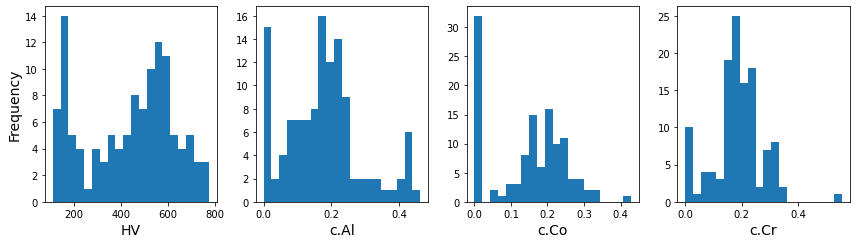

In [105]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5))

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

### Question
1. What is the use of visualizing target property and features data? Give examples of a few scenarios where data visualization could be helpful.

### 3. Train an ML model

In [106]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

#### Our own LR code using the equation discuseed in class

In [107]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X))
X_tras_y = np.dot(X.T,y)
w_cap_vec = np.dot(X_tras_X_inv,X_tras_y)
y_pred_manual = np.dot(X,w_cap_vec)

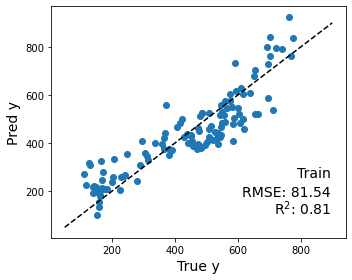

In [108]:
polt_parity(y,y_pred_manual, label="Train")

#### Using sklearn in-built python library

In [109]:
lr = LinearRegression(fit_intercept=False)
model = lr.fit(X,y)
lr_model = copy.deepcopy(model)

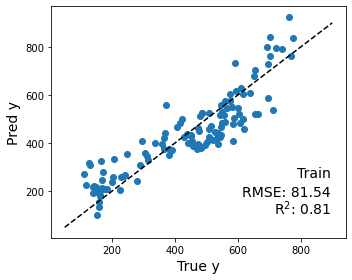

In [110]:
y_pred = model.predict(X)
polt_parity(y,y_pred, label="Train")

#### Comparing sklearn library vs our equation results 

In [111]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


#### Error with baseline average model

In [112]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


### Question
2. Why is it important to compare model performance with a baseline model?
3. Is there any issue with the way we have computed the accuracy/ performance of the linear regression model?

### 4. Model assessment, cross-validation

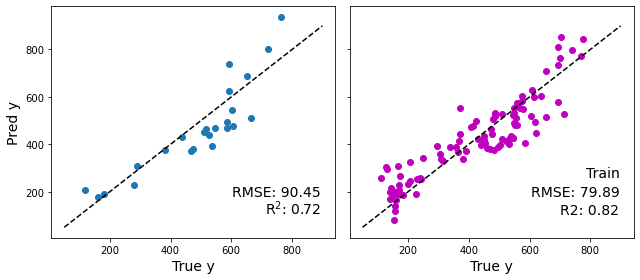

Root mean squared error: 90.45
Coefficient of determination: 0.72


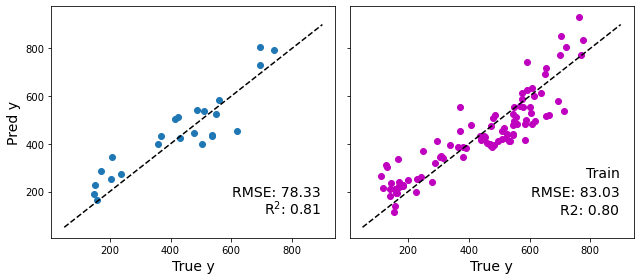

Root mean squared error: 78.33
Coefficient of determination: 0.81


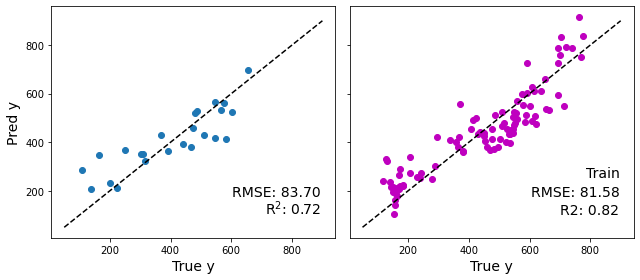

Root mean squared error: 83.70
Coefficient of determination: 0.72


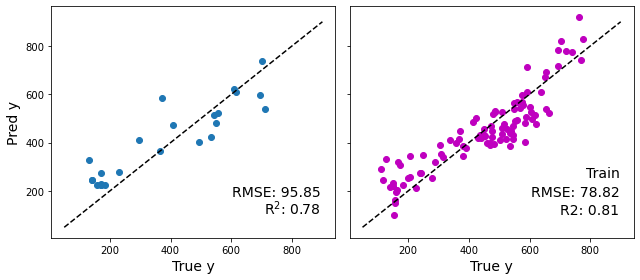

Root mean squared error: 95.85
Coefficient of determination: 0.78


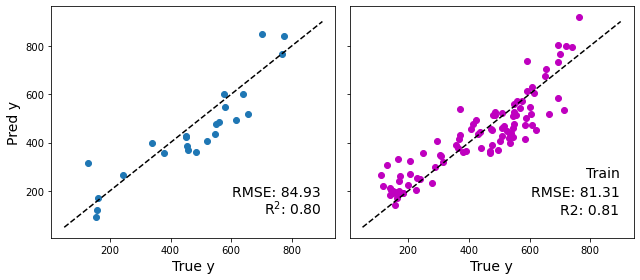

Root mean squared error: 84.93
Coefficient of determination: 0.80


In [113]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, test) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_test = X.values[test]

    y_cv_train = y.values[train]
    y_cv_test = y.values[test]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_test = model.predict(X_cv_test)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_test = np.sqrt(mean_squared_error(y_cv_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_test = r2_score(y_cv_test, y_pred_test)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_test,y_pred_test, y_cv_train,y_pred_train)

    print("Root mean squared error: %.2f" % rmse_test)
    print("Coefficient of determination: %.2f" % r2_test) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_test': rmse_test,
             'r2_test': r2_test
            }

    errors.append(error)

In [114]:
errors = pd.DataFrame(errors)
errors

,kfold,rmse_train,r2_train,rmse_test,r2_test
0,1,79.891078,0.818285,90.450355,0.718613
1,2,83.029464,0.804019,78.328806,0.812832
2,3,81.581612,0.819266,83.698950,0.722233
3,4,78.818495,0.805308,95.850394,0.782430
4,5,81.308911,0.805815,84.927433,0.797547


### Question
4. Why error on training set is consistently lower than that on validation set?
5. Further, the errors on various validation sets are also different. Which is the correct value that best *estimate* the performance of the ML model? 

In [119]:
errors[['rmse_test','r2_test']].mean()

rmse_test    86.651188
r2_test       0.766731
dtype: float64

### Question
6. Is MSE on training data expected to be higher or lower than that on validation/test errors? Discuss.
7. For various values of k-folds, ranging from 2-10, plot average validation RMSE error. Discuss the behavior of the obtained plot.